## imports

### packages import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/LAB medical robotics/project/ROBOTICS RNN/shared_MedRob/'
# %cd '/content/drive/MyDrive/Colab Notebooks/LAB medical robotics/project/final'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1n3PCaxwgapdMq2l7krzsonuqooBZHgbA/ROBOTICS RNN/shared_MedRob


In [ ]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow import metrics
from keras import layers as tfkl
import keras_tuner
from tensorflow.keras import regularizers

### data import

we load the dataset that has been transformed so that the positions are expressed with regards to (w.r.t.) the tips starting position
- this was done in a separate script called "transform_data.ipynb"

In [ ]:
# %cd ../..
# %ls 'data_final'/
%ls data/

test.xlsx                train_25ML_transf.xlsx  training_100ML.xlsx  training_50ML.xlsx
train_100ML_transf.xlsx  train_50ML_transf.xlsx  training_25ML.xlsx   tuner_hyperparams/


In [ ]:
data100 = pd.read_excel('data/train_100ML_transf.xlsx')
data50 = pd.read_excel('data/train_50ML_transf.xlsx')
data25 = pd.read_excel('data/train_25ML_transf.xlsx')

#### removing parts of data

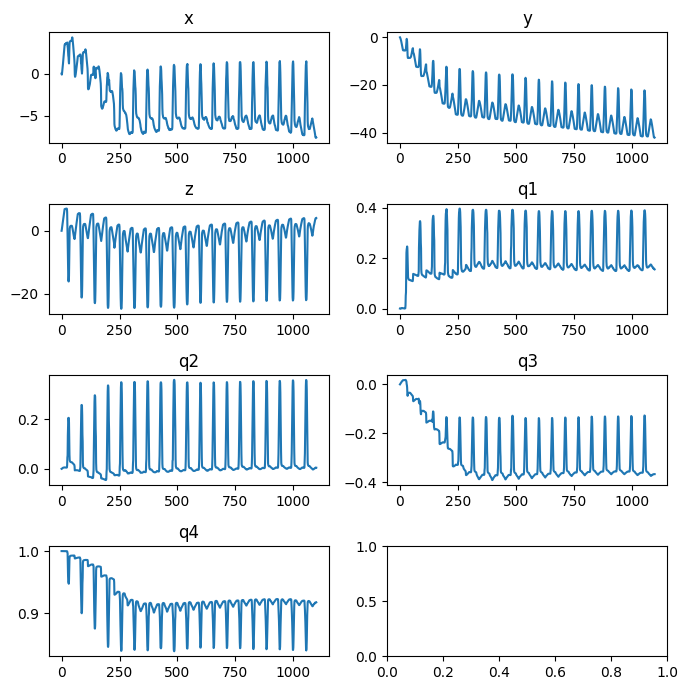

In [ ]:
data100 = data100.drop(data100.index[1100:])
import pandas as pd
import matplotlib.pyplot as plt

last_seven_columns = data100.columns[-7:]

fig, axes = plt.subplots(4, 2, figsize=(7,7))  # Adjust figsize as needed

for i, column in enumerate(last_seven_columns):
    ax = axes[i // 2, i % 2]
    data100[column].plot(kind='line', title=column, ax=ax)

plt.tight_layout()
plt.show()

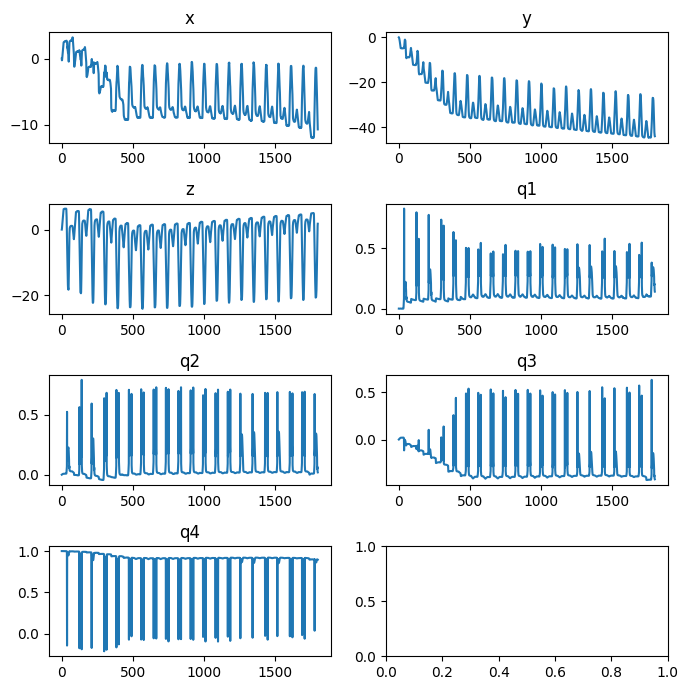

In [ ]:
data50 = data50.drop(data50.index[1800:])

# Plot each column
last_seven_columns = data50.columns[-7:]

fig, axes = plt.subplots(4, 2, figsize=(7,7))  # Adjust figsize as needed

for i, column in enumerate(last_seven_columns):
    ax = axes[i // 2, i % 2]
    data50[column].plot(kind='line', title=column, ax=ax)

plt.tight_layout()
plt.show()

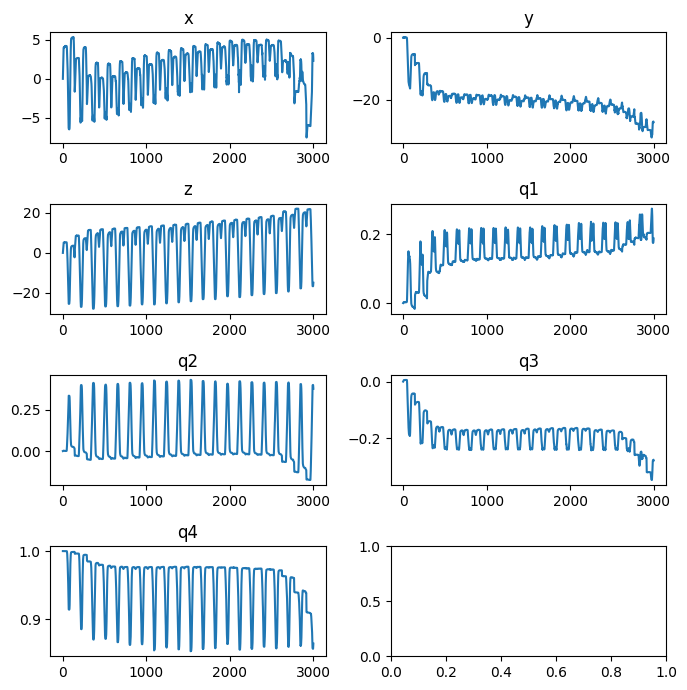

In [ ]:
data25 = data25.drop(data25.index[3000:])
last_seven_columns = data25.columns[-7:]

fig, axes = plt.subplots(4, 2, figsize=(7,7))  # Adjust figsize as needed

for i, column in enumerate(last_seven_columns):
    ax = axes[i // 2, i % 2]
    data25[column].plot(kind='line', title=column, ax=ax)

plt.tight_layout()
plt.show()

## preprocessing

preprocessing steps for every file:
- [x] check if there are any 0's
- [x] transform data to be expressed wrt starting position (another script)
- [ ] do delta's for every dataset - optional
- [x] scale data
- [x] build sequences, i.e. windows of data

### 1st approach: original motor values

#### scaling

we fit the scaler only on the train set
- we create a big array of training data from all 3 datasets to fit the scaler on

how many scalers?
- every column needs to be scaled, but we should use the same scaler on all datasets
- when testing, we'll only have the aurora positions, without motor values -> need to be separated
- a scaler can handle multiple columns, scaling them separately
- calculated motor deltas should be scaled with a separate scaler

=> 3 scalers, for the motor values, motor value differences (deltas) and poses

In [ ]:
data100

,LIN,ML,AP,x,y,z,q1,q2,q3,q4
0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1,0,0,0,-0.126524,-0.195647,0.371246,-0.000208,0.000528,0.001515,0.999999
2,200,0,0,0.034815,-0.393481,1.000663,-0.000768,0.000469,0.003292,0.999994
3,400,0,0,0.296844,-0.724462,1.571550,-0.000035,0.001125,0.004625,0.999989
4,600,0,0,0.576699,-1.088147,2.071307,0.000981,0.002461,0.005573,0.999981
...,...,...,...,...,...,...,...,...,...,...
1095,2200,0,1900,-7.405599,-41.424596,3.674131,0.158928,0.003126,-0.366772,0.916630
1096,2400,0,1900,-7.589370,-42.066467,3.951525,0.156359,0.004916,-0.366709,0.917089
1097,2400,0,1900,-7.535865,-42.021821,3.918354,0.156697,0.004588,-0.366964,0.916931
1098,2400,100,1900,-7.540369,-42.015607,3.981257,0.155812,0.004687,-0.366883,0.917114


a custom train_test_split function allowing further manipulation of datasets if needed

In [ ]:
from sklearn.model_selection import train_test_split

def train_test_split_custom(X, y, test_size):

  # this part is discarded because build_sequences would include a jump
  # # we take the last n rows to include in the train set (so that we scale better)
  # n = 5
  # X_train_add = X[-n:]
  # y_train_add = y[-n:]

  # # consequently, we remove these rows from the rest of the data
  # X = X[:-n]
  # y = y[:-n]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

  # X_train = pd.concat([X_train, X_train_add])
  # y_train = pd.concat([y_train, y_train_add])

  return X_train, X_val, X_test, y_train, y_val, y_test


In [ ]:
X_train_all_unsc = []
y_train_all_unsc = []

X_val_all_unsc = []
y_val_all_unsc = []

X_test_all_unsc = []
y_test_all_unsc = []

In [ ]:
data_list = [data100, data50, data25]

In [ ]:
test_size = 50

In [ ]:
for i in range(len(data_list)):

  X = data_list[i].iloc[:,3:]
  y = data_list[i].iloc[:,:3]

  X_train, X_val, X_test, y_train, y_val, y_test = train_test_split_custom(X,y,test_size)

  X_train_all_unsc.append(X_train)
  y_train_all_unsc.append(y_train)

  X_val_all_unsc.append(X_val)
  y_val_all_unsc.append(y_val)

  X_test_all_unsc.append(X_test)
  y_test_all_unsc.append(y_test)

In [ ]:
# putting all train data together, to be used for fitting the scalers
x_train_arr = np.vstack(X_train_all_unsc)
x_train_df = pd.DataFrame(x_train_arr,columns=data100.columns[3:])
y_train_arr = np.vstack(y_train_all_unsc)
y_train_df = pd.DataFrame(y_train_arr,columns=data100.columns[:3])
x_train_arr.shape

(4600, 7)

In [ ]:
X_train_all = []
y_train_all = []

X_val_all = []
y_val_all = []

X_test_all = []
y_test_all = []

#### creating the motor deltas dataset for the output

In [ ]:
def make_deltas(y):
    '''
    Parameters:
    y - pandas DataFrame
    '''
    columns = y.columns
    deltas = np.array(y[1:])-np.array(y[:-1])
    return pd.DataFrame(deltas,columns=columns)

In [ ]:
y_delta_train_all_unsc = []
y_delta_val_all_unsc = []
y_delta_test_all_unsc = []

for i in range(len(y_train_all_unsc)):
    y_delta_train_all_unsc += [make_deltas(y_train_all_unsc[i])]
    y_delta_val_all_unsc += [make_deltas(y_val_all_unsc[i])]
    y_delta_test_all_unsc += [make_deltas(y_test_all_unsc[i])]

len(y_delta_train_all_unsc)

3

In [ ]:
y_delta_train_df = np.vstack(y_delta_train_all_unsc)
y_delta_train_df = pd.DataFrame(y_delta_train_df,columns=data100.columns[:3])

In [ ]:
y_delta_train_all = []
y_delta_val_all = []
y_delta_test_all = []

#### cont

In [ ]:
X_train_all = []
y_train_all = []

X_val_all = []
y_val_all = []

X_test_all = []
y_test_all = []

In [ ]:
scaler_pos = MinMaxScaler(feature_range=(0,1))
scaler_motor = MinMaxScaler(feature_range=(0,1))
scaler_delta = MinMaxScaler(feature_range=(0,1))

scaler_pos.fit(x_train_df)
scaler_motor.fit(y_train_df)
scaler_delta.fit(y_delta_train_df)

# now do scaler.transform for all, keeping them separate
for i in range(len(X_train_all_unsc)):

    X_train_all += [scaler_pos.transform(X_train_all_unsc[i])]
    y_train_all += [scaler_motor.transform(y_train_all_unsc[i])]
    y_delta_train_all += [scaler_delta.transform(y_delta_train_all_unsc[i])]

    X_val_all += [scaler_pos.transform(X_val_all_unsc[i])]
    y_val_all += [scaler_motor.transform(y_val_all_unsc[i])]
    y_delta_val_all += [scaler_delta.transform(y_delta_val_all_unsc[i])]

    X_test_all += [scaler_pos.transform(X_test_all_unsc[i])]
    y_test_all += [scaler_motor.transform(y_test_all_unsc[i])]
    y_delta_test_all += [scaler_delta.transform(y_delta_test_all_unsc[i])]


In [ ]:
# TEST - see if the scaler works
np.allclose(scaler_motor.inverse_transform(y_train_all[0]),y_train_all_unsc[0])

True

note: some of X_val_all are negative bc the scaler was fit on the train sets

In [ ]:
np.min(X_val_all[2])

-0.14325886210741784

#### building sequences

for each of the train/test sets, we need to build time windows (careful not to take windows across different datasets)
- after this, we can mix them in one big dataset

In [ ]:
def build_sequences(dataX, datay, window, stride, pred_window, dataDelta=None):

    """
    Build sequences from input data to create time windows.

    Parameters:
    - dataX (numpy.ndarray): Input data representing points in space.
    - datay (numpy.ndarray): Motor movements corresponding to the input data.
    - window (int): Size of the input window (number of steps in a sequence).
    - stride (int): Stride between consecutive windows.
    - pred_window (int): Size of the prediction window.

    Returns:
    - xt (numpy.ndarray): Input sequences containing both spatial points and motor movements.
    - yt (numpy.ndarray): Output sequences representing the succeeding motor movements.

    Note:
    - The function asserts that window % stride == 0.
    - Sequences are constructed by taking windows from dataX and concatenating corresponding motor movements from datay.
    - The stride parameter determines the step between the start of consecutive windows.
    - The pred_window parameter specifies the size of the prediction window.
    """

    assert window % stride == 0

    xt = []
    yt = []
    # make windows every /stride/ steps
    # i is start of a window
    for i in range(0,len(dataX)-window-pred_window,stride):
        # we take a window of the motor movements (y) and concatenate the next target position
        X_new = np.column_stack((dataX[i:i+window],datay[i:i+window],dataX[i+1:i+window+1]))
        # we predict (output) the difference of motor movements we need to do to reach it
        if dataDelta is not None:
            # data delta starts one point ahead, so we substract 1
            # we want to be in the same row as dataX[i+1:i+window+1]
            y_new = dataDelta[i+window-1:i+window+pred_window-1]
        else:
            y_new = datay[i+window:i+window+pred_window]

        xt.append(X_new)
        yt.append(y_new)

    xt = np.asarray(xt)
    yt = np.asarray(yt)

    return xt, yt

In [ ]:
window = 25
stride = 1
pred_window = 1

if necessary, we can turn window/stride into a list to choose size according to the dataset

In [ ]:
def get_final_sets(x_all,y_all,window,stride,pred_window,y_delta=None, stack=True):

    '''
    Parameters:
    x_all: list of np.arrays - list that contains samples for each dataset
    '''

    size_list = []

    X_set = []
    y_set = []

    for i in range(len(x_all)):
        # i should be [0,2]
        # print(X_train_all[i].shape)
        xx, yy = build_sequences(np.copy(x_all[i]),np.copy(y_all[i]),window,stride,pred_window,dataDelta=np.copy(y_delta[i]))
        X_set.append(xx)
        y_set.append(yy)

        # store size of set for every dataset
        size_list += [len(yy)]

    if stack:
        X_set = np.vstack(X_set)
        y_set = np.vstack(y_set)

    return X_set, y_set, size_list

In [ ]:
len(X_train_all[2])

2360

In [ ]:
window_test = window

In [ ]:
# we put stack=False if we want to keep the set as a list separated by datasets, instead of stacking all together
X_train, y_train, train_sizes = get_final_sets(X_train_all, y_train_all, window,stride,pred_window,y_delta=y_delta_train_all) #,stack=False)
X_val, y_val, _ = get_final_sets(X_val_all, y_val_all, window,stride,pred_window,y_delta=y_delta_val_all)
X_test, y_test, _ = get_final_sets(X_test_all, y_test_all, window_test, stride,pred_window,y_delta=y_delta_test_all)

In [ ]:
# TEST - is size of train as expected
# total_size_train = sum(t.shape[0] for t in X_train)
total_size_train = len(X_train)

total_size_train_og = sum(t.shape[0] for t in y_train_all)
total_size_train_exp = total_size_train_og/stride - 3*(window+pred_window)
print(f'train size (total): {total_size_train}, expected: {round(total_size_train_exp)}')

train size (total): 113050, expected: 4522


## classification

### stateless models

In [ ]:
# turn X and y _train from list of 3 to complete np array
if len(X_train) == 3:
  print('X_train was still a list')
  X_train = np.vstack(X_train)
  y_train = np.vstack(y_train)

In [ ]:
input_shape = X_train.shape[1:3]
output_shape = y_train.shape[1:3]
print(input_shape, output_shape)

(25, 10) (1, 3)


#### model 1
- this is a model with a lot of variable parameters that can be tuned by keras tuner

In [ ]:
def build_model_tuned(hp):

  # for a model that is used with keras tuning, we need to manually insert input and output shapes
  input_shape = (25,10)
  output_shape = (1,3)

  input_layer = tfkl.Input(shape=input_shape, name='input_layer')

  units1 = hp.Choice('units1',[512,256,128,64])
  dropout_lstm = hp.Choice('dropout_lstm',[0.0,1/5])
  x = tfkl.Bidirectional(tfkl.LSTM(units1, return_sequences=True, recurrent_dropout=dropout_lstm, name='lstm0'),name='bidirectional')(input_layer)

  filters = hp.Int('filters', min_value=30, max_value=100, step=10)
  kernel_size = hp.Choice('kernel_size',[2,3,5,6])

  x = tfkl.Conv1D(filters, kernel_size, padding='same', activation='relu', name='conv2')(x)
  x = tfkl.Flatten()(x)

  units_dense = hp.Int('units_dense',min_value=40,max_value=100,step=20)
  dropout = hp.Choice('dropout',[1/5,1/4,1/6])
  x = tfkl.Dense(units_dense, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(), kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))(x)
  x = tfkl.Dropout(1/5)(x)

  # Add a final Convolution layer to match the desired output shape
  output_layer = tfkl.Dense(3, activation='relu')(x)

  # Construct the model by connecting input and output layers
  model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model_tuned')

  model.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(1e-4),
    loss='mae',
    metrics=[metrics.MeanSquaredError()] # mape shouldn't be used if we have zeros
  )

  return model
  return model

#### model 2: simpler
- this model goes straight to Dense without convolutional layers
- also to be tuned with the keras tuner

In [ ]:
def build_model_tuned(hp):

  # for a model that is used with keras tuning, we need to manually insert input and output shapes
  input_shape = (25,10)
  output_shape = (1,3)

  input_layer = tfkl.Input(shape=input_shape, name='input_layer')

  # dropout_lstm = hp.Choice('dropout_lstm',[0.0,1/5,1/2])
  dropout_lstm = 0.3
  units_lstm = hp.Choice('lstm_units',[32])
  x = tfkl.LSTM(units_lstm, return_sequences=True, recurrent_dropout=dropout_lstm, name='lstm0')(input_layer)

  # filters = hp.Int('filters', min_value=30, max_value=100, step=10)
  # kernel_size = hp.Choice('kernel_size',[3,5])

  # x = tfkl.Conv1D(filters, kernel_size, padding='same', activation='relu', name='conv2')(x)
  x = tfkl.Flatten()(x)

  # units_dense = hp.Int('units_dense',min_value=40,max_value=100,step=20)
  units_dense = 32
  # dropout = hp.Choice('dropout',[1/5,1/4,1/6])
  # activation = hp.Choice('activation',['relu','sigmoid','tanh','softmax'])

  x = tfkl.Dense(units_dense, activation='relu')(x)


  # x = tfkl.Dropout(1/5)(x)
  # Add a final Convolution layer to match the desired output shape
  output_layer = tfkl.Dense(3, activation='relu')(x)
  # Construct the model by connecting input and output layers
  model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='simple_model_tuned' )

  model.compile(
    # optimizer = tf.keras.optimizers.Adam(1e-4),
    optimizer = tf.keras.optimizers.legacy.Adam(1e-4),
    loss='mae',
    metrics=[metrics.MeanSquaredError()] # mape shouldn't be used if we have zeros
  )

  return model

#### model from manual tuning

In [ ]:
help(keras_tuner.BayesianOptimization)

Help on class BayesianOptimization in module keras_tuner.src.tuners.bayesian:

class BayesianOptimization(keras_tuner.src.engine.tuner.Tuner)
 |  BayesianOptimization(hypermodel=None, objective=None, max_trials=10, num_initial_points=None, alpha=0.0001, beta=2.6, seed=None, hyperparameters=None, tune_new_entries=True, allow_new_entries=True, max_retries_per_trial=0, max_consecutive_failed_trials=3, **kwargs)
 |  
 |  BayesianOptimization tuning with Gaussian process.
 |  
 |  Args:
 |      hypermodel: Instance of `HyperModel` class (or callable that takes
 |          hyperparameters and returns a `Model` instance). It is optional
 |          when `Tuner.run_trial()` is overridden and does not use
 |          `self.hypermodel`.
 |      objective: A string, `keras_tuner.Objective` instance, or a list of
 |          `keras_tuner.Objective`s and strings. If a string, the direction of
 |          the optimization (min or max) will be inferred. If a list of
 |          `keras_tuner.Objective

In [ ]:
help(tfkl.Attention())

Help on Attention in module keras.src.layers.attention.attention object:

class Attention(keras.src.layers.attention.base_dense_attention.BaseDenseAttention)
 |  Attention(*args, **kwargs)
 |  
 |  Dot-product attention layer, a.k.a. Luong-style attention.
 |  
 |  Inputs are `query` tensor of shape `[batch_size, Tq, dim]`, `value` tensor
 |  of shape `[batch_size, Tv, dim]` and `key` tensor of shape
 |  `[batch_size, Tv, dim]`. The calculation follows the steps:
 |  
 |  1. Calculate scores with shape `[batch_size, Tq, Tv]` as a `query`-`key` dot
 |      product: `scores = tf.matmul(query, key, transpose_b=True)`.
 |  2. Use scores to calculate a distribution with shape
 |      `[batch_size, Tq, Tv]`: `distribution = tf.nn.softmax(scores)`.
 |  3. Use `distribution` to create a linear combination of `value` with
 |       shape `[batch_size, Tq, dim]`:
 |       `return tf.matmul(distribution, value)`.
 |  
 |  Args:
 |      use_scale: If `True`, will create a scalar variable to scale t

In [ ]:
import keras.initializers as kinit

def build_model_tuned(hp):

  # for a model that is used with keras tuning, we need to manually insert input and output shapes
  input_shape = (25,17)
  output_shape = (None,3)

  input_layer = tfkl.Input(shape=input_shape, name='input_layer')

  dropout_lstm = hp.Choice('dropout_lstm',[0.2,0.3,0.5])
  # dropout_lstm = 0.3
  units_lstm = hp.Choice('lstm_units',[32,64,100,128,256])
  # units_lstm = 32
  x = tfkl.LSTM(units_lstm, return_sequences=True, recurrent_dropout=dropout_lstm, kernel_regularizer=regularizers.l2(0.01), name='lstm1')(input_layer)
  # x = tfkl.Attention()(x)
  # filters = hp.Int('filters', min_value=30, max_value=100, step=10)
  # kernel_size = hp.Choice('kernel_size',[3,5])

  conv_units1 = hp.Choice('conv_units1',[32,64])
  kernel_size = hp.Choice('kernel_size',[3,5])
  x = tfkl.Conv1D(conv_units1, kernel_size, padding='same', activation='relu', name='conv1')(x)
  bn_conv = hp.Boolean('bn_conv')
  if bn_conv:
    x = tfkl.BatchNormalization()(x)
  conv_units2 = hp.Choice('conv_units2',[128,256])
  x = tfkl.Conv1D(conv_units2, 3, padding='same', activation='relu', name='conv2')(x)
  x = tfkl.Flatten()(x)

  x = tfkl.BatchNormalization()(x)

  x = tfkl.Dense(16, kernel_regularizer=regularizers.l2(0.01), kernel_initializer=kinit.HeUniform(), activation='relu')(x)


  # x = tfkl.Dropout(1/5)(x)
  # Add a final Convolution layer to match the desired output shape
  output_layer = tfkl.Dense(3, activation='linear')(x)
  # Construct the model by connecting input and output layers
  model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='simple_model_manual' )


  model.compile(
  # optimizer = tf.keras.optimizers.Adam(1e-4),
  optimizer = tf.keras.optimizers.legacy.Adam(1e-4),
  loss='mae',
  metrics=[metrics.MeanSquaredError()] # mape shouldn't be used if we have zeros
  )

  return model

### keras tuning

In [ ]:
import keras_tuner

#
tuner = keras_tuner.BayesianOptimization(
    build_model_tuned,
    objective='val_loss',
    max_trials=60,
    directory='tuner_hyperparams/delta',
    project_name='LSTMCONV_1502_1',

)

In [ ]:
cb_early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
cb_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.1, min_lr=1e-5)

In [ ]:
y_train.shape

(4522, 1, 3)

In [ ]:
start_time = time.time()
tuner.search(X_train, y_train, epochs=500, validation_data=(X_val, y_val),callbacks=[cb_early_stop, cb_lr])
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Trial 7 Complete [00h 07m 28s]
val_loss: 0.09662771970033646

Best val_loss So Far: 0.09581661969423294
Total elapsed time: 01h 55m 45s

Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
0.5               |0.5               |dropout_lstm
256               |100               |lstm_units
64                |32                |conv_units1
3                 |3                 |kernel_size
True              |False             |bn_conv
128               |128               |conv_units2

Epoch 1/500
142/142 [==============================] - 34s 212ms/step - loss: 0.7699 - mean_squared_error: 0.1666 - val_loss: 0.7350 - val_mean_squared_error: 0.1436 - lr: 1.0000e-04
Epoch 2/500
142/142 [==============================] - 29s 208ms/step - loss: 0.6539 - mean_squared_error: 0.1165 - val_loss: 0.6086 - val_mean_squared_error: 0.0973 - lr: 1.0000e-04
Epoch 3/500
142/142 [==============================] - 30s 209ms/step - loss: 0.5683 - mean_squared_error: 0.0874 - val_l

KeyboardInterrupt: 

In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]
best_hps.values

{'dropout_lstm': 0.5,
 'lstm_units': 100,
 'conv_units1': 32,
 'kernel_size': 3,
 'bn_conv': False,
 'conv_units2': 128}

In [ ]:
model = tuner.hypermodel.build(best_hps)

### manually tuned model to adjust the weights to make the network focus on the component on which makes the highest error

In [ ]:
import keras.initializers as kinit

def build_model(input_shape=None, output_shape=None):

  # for a model that is used with keras tuning, we need to manually insert input and output shapes
  # input_shape = (15,10)
  # output_shape = (None,3)

  input_layer = tfkl.Input(shape=input_shape, name='input_layer')

  # dropout_lstm = hp.Choice('dropout_lstm',[0.0,1/5,1/2])
  dropout_lstm = 0.3
  # units_lstm = hp.Choice('lstm_units',[32])
  units_lstm = 32
  x = tfkl.LSTM(units_lstm, return_sequences=True, recurrent_dropout=dropout_lstm, kernel_regularizer=regularizers.l2(0.01), name='lstm1')(input_layer)

  # filters = hp.Int('filters', min_value=30, max_value=100, step=10)
  # kernel_size = hp.Choice('kernel_size',[3,5])

  x = tfkl.Conv1D(64, 3, padding='same', activation='relu', name='conv1')(x)
  x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv2')(x)
  x = tfkl.Flatten()(x)

  x = tfkl.BatchNormalization()(x)

  x = tfkl.Dense(16, kernel_regularizer=regularizers.l2(0.01), kernel_initializer=kinit.HeUniform(), activation='relu')(x)


  # x = tfkl.Dropout(1/5)(x)
  # Add a final Convolution layer to match the desired output shape
  output_layer = tfkl.Dense(3, activation='relu')(x)
  # Construct the model by connecting input and output layers
  model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='simple_model_manual' )

  # optional model.compile()

  return model

#### weight the loss function for each component to alllow the network to focus more on one of the output loss 

In [ ]:
def weighted_mae(y_true, y_pred, loss_weights):
    lossLIN = tf.reduce_mean(tf.abs(y_true[:, 0] - y_pred[:, 0]))
    lossML = tf.reduce_mean(tf.abs(y_true[:, 1] - y_pred[:, 1]))
    lossAP = tf.reduce_mean(tf.abs(y_true[:, 2] - y_pred[:, 2]))

    weighted_loss = loss_weights['lossLIN'] * lossLIN + loss_weights['lossML'] * lossML + loss_weights['lossAP'] * lossAP

    return weighted_loss

In [ ]:
loss_weights = {'lossLIN': 1.0, 'lossML': 2.0, 'lossAP': 3.0}

In [ ]:
input_shape = (25,17)
output_shape = (None,3)

model = build_model(input_shape,output_shape)
# Compile your model with the custom loss function
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(1e-4),
    # optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=lambda y_true, y_pred: weighted_mae(y_true, y_pred, loss_weights))


### fitting the actual model

In [ ]:
model.summary()

Model: "simple_model_manual"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 25, 10)]          0         
                                                                 
 lstm1 (LSTM)                (None, 25, 100)           44400     
                                                                 
 conv1 (Conv1D)              (None, 25, 32)            9632      
                                                                 
 conv2 (Conv1D)              (None, 25, 128)           12416     
                                                                 
 flatten_2 (Flatten)         (None, 3200)              0         
                                                                 
 batch_normalization_3 (Bat  (None, 3200)              12800     
 chNormalization)                                                
                                               

In [ ]:
class LossCallback(keras.callbacks.Callback):
    def __init__(self, validation_data, loss_weights):
        super(LossCallback, self).__init__()
        self.validation_data = validation_data
        self.losses = {'lossLIN': [], 'lossML': [], 'lossAP': []}  # Initialize empty lists for losses
        self.loss_weights = loss_weights  # in case we want to penalise some losses more than others

    def on_epoch_end(self, epoch, logs=None):
        # Predict on validation data
        predictions = self.model.predict(self.validation_data[0])

        # Reshape y_val if necessary
        y_val = np.squeeze(self.validation_data[1])  # Remove extra dimension if present

        # Compute loss for each value separately (MAE)
        lossLIN = np.mean(np.abs(y_val[:, 0] - predictions[:, 0])) * self.loss_weights['lossLIN']
        lossML = np.mean(np.abs(y_val[:, 1] - predictions[:, 1])) * self.loss_weights['lossML']
        lossAP = np.mean(np.abs(y_val[:, 2] - predictions[:, 2])) * self.loss_weights['lossAP']

        # Store losses
        self.losses['lossLIN'].append(lossLIN)
        self.losses['lossML'].append(lossML)
        self.losses['lossAP'].append(lossAP)

        # Print loss for each value
        print(f"\nEpoch {epoch+1}, LossLIN: {lossLIN}, LossML: {lossML}, LossAP: {lossAP}\n\n")


In [ ]:
# Ensure y_train has shape (batch_size, 3)
y_train_sq = np.squeeze(y_train, axis=1)  # Remove the extra dimension
y_val_sq = np.squeeze(y_val,axis=1)

# Ensure the shape of X_train and y_train_sq matches the expected input shape for your LSTM model
print("X_train shape before:", X_train.shape)
print(f"y_train_sq shape before: {y_train.shape} and after {y_train_sq.shape}")
print(f"y_train_sq shape before: {y_val.shape} and after {y_val_sq.shape}")

X_train shape before: (4522, 25, 10)
y_train_sq shape before: (4522, 1, 3) and after (4522, 3)
y_train_sq shape before: (1072, 1, 3) and after (1072, 3)


In [ ]:
validation_data = (X_val,y_val)  # Adjust weights as needed
validation_data_sq = (X_val,y_val_sq)
loss_callback = LossCallback(validation_data_sq,loss_weights)

In [ ]:
model_name = 'tuned_model_1502_1'

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=10),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5,min_lr=1e-5),
    # keras.callbacks.ModelCheckpoint(filepath='models/simple_conv_0902_7.{epoch:02d}-{val_loss:.2f}.h5'),
    keras.callbacks.ModelCheckpoint(filepath=f"checkpoints/all_data/{model_name}_checkpoint",
                                                                     save_weights_only=False,
                                                                     monitor='val_loss',
                                                                      mode='min',
                                                                      save_best_only=True),
    keras.callbacks.TensorBoard(log_dir='./logs'),
    loss_callback
]

In [ ]:
num_epochs = 300

need to add reduce on plateau or some other type of lr reduction callback - results too jumpy, step too big

In [ ]:
import time
start_time = time.time()


#  Retrain the model
history = model.fit(
    x = X_train,
    y = y_train_sq,
    epochs=num_epochs,
    validation_data = validation_data_sq,
    callbacks = callbacks

).history


elapsed_time = time.time() - start_time
print(f"\nElapsed time: {elapsed_time} seconds")


Epoch 1/300
34/34 [==============================] - 1s 12ms/step

Epoch 1, LossLIN: 0.3878527528175445, LossML: 0.8586604544873794, LossAP: 0.030783582089552237


142/142 [==============================] - 53s 115ms/step - loss: 0.6733 - mean_squared_error: 0.1261 - val_loss: 0.6531 - val_mean_squared_error: 0.1420 - lr: 1.0000e-04
Epoch 2/300
34/34 [==============================] - 0s 12ms/step

Epoch 2, LossLIN: 0.3727225263589131, LossML: 0.8166042895007656, LossAP: 0.030783582089552237


142/142 [==============================] - 14s 102ms/step - loss: 0.4729 - mean_squared_error: 0.0620 - val_loss: 0.5604 - val_mean_squared_error: 0.1321 - lr: 1.0000e-04
Epoch 3/300
34/34 [==============================] - 0s 11ms/step

Epoch 3, LossLIN: 0.2948674143243359, LossML: 0.5068060240722192, LossAP: 0.030783582089552237


142/142 [==============================] - 14s 99ms/step - loss: 0.3651 - mean_squared_error: 0.0322 - val_loss: 0.4304 - val_mean_squared_error: 0.0679 - lr: 1.0000e

##### chatGPT trying to fix things so that logs includes 'lossLIN' etc - DIDN'T WORK

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

def weighted_mae(y_true, y_pred, loss_weights):
    lossLIN = tf.reduce_mean(tf.abs(y_true[:, 0] - y_pred[:, 0]))
    lossML = tf.reduce_mean(tf.abs(y_true[:, 1] - y_pred[:, 1]))
    lossAP = tf.reduce_mean(tf.abs(y_true[:, 2] - y_pred[:, 2]))

    # Store individual loss components in logs dictionary
    logs = {'lossLIN': lossLIN, 'lossML': lossML, 'lossAP': lossAP}

    weighted_loss = loss_weights['lossLIN'] * lossLIN + loss_weights['lossML'] * lossML + loss_weights['lossAP'] * lossAP

    # Include standard losses in the logs dictionary
    logs['loss'] = weighted_loss
    logs['val_loss'] = weighted_loss

    return weighted_loss, logs

loss_weights = {'lossLIN': 1.0, 'lossML': 2.0, 'lossAP': 3.0}

# Model compilation
model = build_model()
model.compile(optimizer='adam', loss=lambda y_true, y_pred: weighted_mae(y_true, y_pred, loss_weights)[0])

class LossHistoryCallback(keras.callbacks.Callback):
    def __init__(self):
        super(LossHistoryCallback, self).__init__()
        self.losses = {'loss': [], 'val_loss': [], 'lossLIN': [], 'lossML': [], 'lossAP': []}

    def on_epoch_end(self, epoch, logs=None):
      print(f"Epoch {epoch}: Logs - {logs}")
      # Store the loss values for each component
      self.losses['loss'].append(logs['loss'])
      self.losses['val_loss'].append(logs['val_loss'])
      self.losses['lossLIN'].append(logs['lossLIN'])  # Make sure these keys are available in logs
      self.losses['lossML'].append(logs['lossML'])
      self.losses['lossAP'].append(logs['lossAP'])

# Training configuration
validation_data = (X_val, y_val)
validation_data_sq = (X_val, y_val_sq)
loss_history_callback = LossHistoryCallback()

callbacks = [
    keras.callbacks.EarlyStopping(patience=10),
    keras.callbacks.ModelCheckpoint(filepath='models/simple_conv_0902_7.{epoch:02d}-{val_loss:.2f}.h5'),
    keras.callbacks.TensorBoard(log_dir='./logs'),
    loss_history_callback
]

# Model training
start_time = time.time()
history = model.fit(
    x=X_train,
    y=y_train_sq,
    epochs=num_epochs,
    validation_data=validation_data_sq,
    callbacks=callbacks
).history
elapsed_time = time.time() - start_time
print(f"\nElapsed time: {elapsed_time} seconds")


Epoch 1/5
146/146 [==============================] - ETA: 0s - loss: 1.2409Epoch 0: Logs - {'loss': 1.2408840656280518, 'val_loss': 2.5898678302764893}


KeyError: 'lossLIN'

In [ ]:
history.keys()

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])

##### cont

In [ ]:
def plot_individual_losses(num_epochs_elapsed,loss_callback,history):
  # Plot losses using the actual number of epochs elapsed
  epochs = range(1, num_epochs_elapsed + 1)
  plt.plot(epochs, loss_callback.losses['lossLIN'][:num_epochs_elapsed], label='LossLIN')
  plt.plot(epochs, loss_callback.losses['lossML'][:num_epochs_elapsed], label='LossML')
  plt.plot(epochs, loss_callback.losses['lossAP'][:num_epochs_elapsed], label='LossAP')
  plt.plot(epochs, history['loss'][:num_epochs_elapsed], label='LossTotal')

  l1 = loss_callback.losses['lossLIN'][:num_epochs_elapsed]
  l2 = loss_callback.losses['lossML'][:num_epochs_elapsed]*2
  l3 = loss_callback.losses['lossAP'][:num_epochs_elapsed]*3
  summ = [sum(x) for x in zip(l1,l2,l3)]
  plt.plot(epochs, summ, label='LossSum')

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Losses for Each Value + total')
  plt.legend()
  plt.show()

In [ ]:
def plot_individual_losses(num_epochs_elapsed,loss_callback,history):
  # Plot losses using the actual number of epochs elapsed
  epochs = range(1, num_epochs_elapsed + 1)
  plt.plot(epochs, loss_callback.losses['lossLIN'][:num_epochs_elapsed], label='LossLIN')
  plt.plot(epochs, loss_callback.losses['lossML'][:num_epochs_elapsed], label='LossML')
  plt.plot(epochs, loss_callback.losses['lossAP'][:num_epochs_elapsed], label='LossAP')
  plt.plot(epochs, history['loss'][:num_epochs_elapsed], label='LossTotal')

  l1 = loss_callback.losses['lossLIN'][:num_epochs_elapsed]
  l2 = [x*2 for x in loss_callback.losses['lossML'][:num_epochs_elapsed]]
  l3 = [x*2 for x in loss_callback.losses['lossAP'][:num_epochs_elapsed]]
  summ = [sum(x) for x in zip(l1,l2,l3)]
  plt.plot(epochs, summ, label='LossWSum')

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Losses for Each Value + total')
  plt.legend()
  plt.show()

second keras tuned model plot


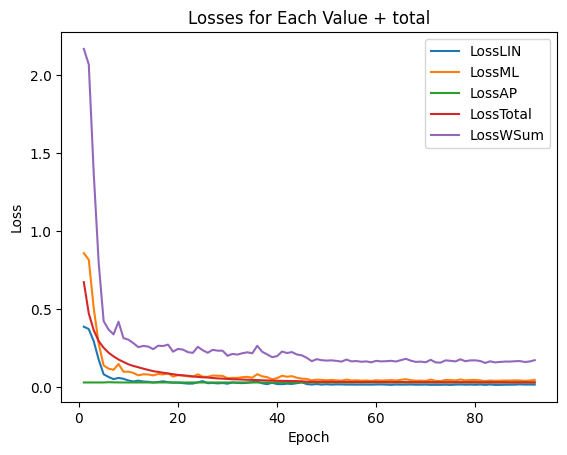

In [ ]:
# keras
print('second keras tuned model plot')
# Get the number of epochs that actually elapsed
num_epochs_elapsed = len(history['loss'])
plot_individual_losses(num_epochs_elapsed,loss_callback,history)

second keras tuned model plot


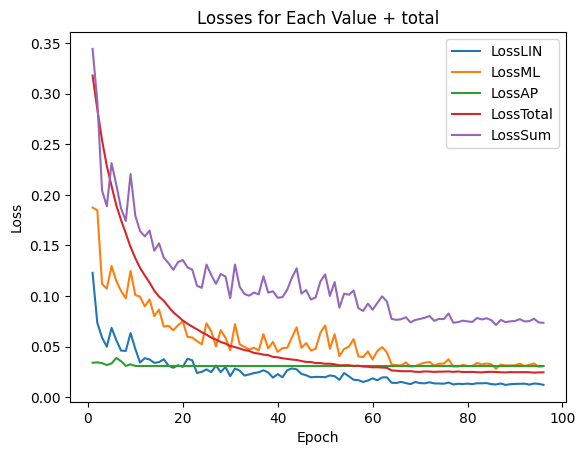

In [ ]:
# keras
print('second keras tuned model plot')
# Get the number of epochs that actually elapsed
num_epochs_elapsed = len(history['loss'])
plot_individual_losses(num_epochs_elapsed,loss_callback,history)

### predictions

#### predictions on test

In [ ]:
X_test.shape

(12, 5, 10)

In [ ]:
# keras tuned new results:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = keras.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = keras.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (72, 3)
Mean Squared Error: 0.006400991231203079
Mean Absolute Error: 0.020971117541193962


check out real predictions (reverse scaling)



In [ ]:
predictions_unsc = scaler_delta.inverse_transform(predictions)
y_test_unsc = scaler_delta.inverse_transform(y_test.reshape(-1,3))

for i in range(len(predictions_unsc)):
  print(f'predicted: {predictions_unsc[i]} -- real: {y_test_unsc[i]}')

predicted: [-200.          -0.5864501    0.       ] -- real: [-200.    0.    0.]
predicted: [-200.          -0.3684044    0.       ] -- real: [-200.    0.    0.]
predicted: [-200.          -1.4612019    0.       ] -- real: [-200.    0.    0.]
predicted: [-200.          -1.5611112    0.       ] -- real: [-200.    0.    0.]
predicted: [-200.          -1.9982457    0.       ] -- real: [-200.    0.    0.]
predicted: [-200.          -2.1900833    0.       ] -- real: [-200.    0.    0.]
predicted: [-200.          -1.7615318    0.       ] -- real: [-200.    0.    0.]
predicted: [-200.          -0.6277621    0.       ] -- real: [-200.    0.    0.]
predicted: [-58.56689   -0.737226   0.      ] -- real: [  0.   0. 100.]
predicted: [68.18504  -2.612871  0.      ] -- real: [0. 0. 0.]
predicted: [192.75433    -1.8077672   0.       ] -- real: [200.   0.   0.]
predicted: [208.25577     0.2831936   0.       ] -- real: [200.   0.   0.]
predicted: [206.8985      1.4186144   0.       ] -- real: [200.   0

#### mae on separate columns

In [ ]:
# keras tuned model new
y_test = y_test.reshape(-1,3)
MAElin = np.mean(np.abs(y_test[:, 0] - predictions[:, 0]))
MAEml = np.mean(np.abs(y_test[:, 1] - predictions[:, 1]))
MAEap = np.mean(np.abs(y_test[:, 2] - predictions[:, 2]))
print(f'MAE lin: {MAElin}\nMAE ml: {MAEml}\nMAE ap: {MAEap}')

MAE lin: 0.016374686112006504
MAE ml: 0.0326497790714105
MAE ap: 0.013888888888888888


In [ ]:
# unscaled MAE
# keras tuned model new
y_test = y_test.reshape(-1,3)
MAElin = np.mean(np.abs(y_test_unsc[:, 0] - predictions_unsc[:, 0]))
MAEml = np.mean(np.abs(y_test_unsc[:, 1] - predictions_unsc[:, 1]))
MAEap = np.mean(np.abs(y_test_unsc[:, 2] - predictions_unsc[:, 2]))
print(f'MAE lin: {MAElin}\nMAE ml: {MAEml}\nMAE ap: {MAEap}')

MAE lin: 6.549871895048353
MAE ml: 6.529953092336655
MAE ap: 1.3888888888888888


imo, it would be useful to calculate the maximum absolute error, since it's a medical device and it's supposed to operate inside a human

In [ ]:
# max absolute error
maxLIN = np.max(np.abs(y_test[:, 0] - predictions[:, 0]))
maxML = np.max(np.abs(y_test[:, 1] - predictions[:, 1]))
maxAP = np.max(np.abs(y_test[:, 2] - predictions[:, 2]))
print('Maximum absolute errors by motor:')
print(f'  lin: {maxLIN}\n  ml: {maxML}\n  ap: {maxAP}')

Maximum absolute errors by motor:
  lin: 0.1697210669517517
  ml: 0.22855323553085327
  ap: 0.9451014921069145


#### prediction plots

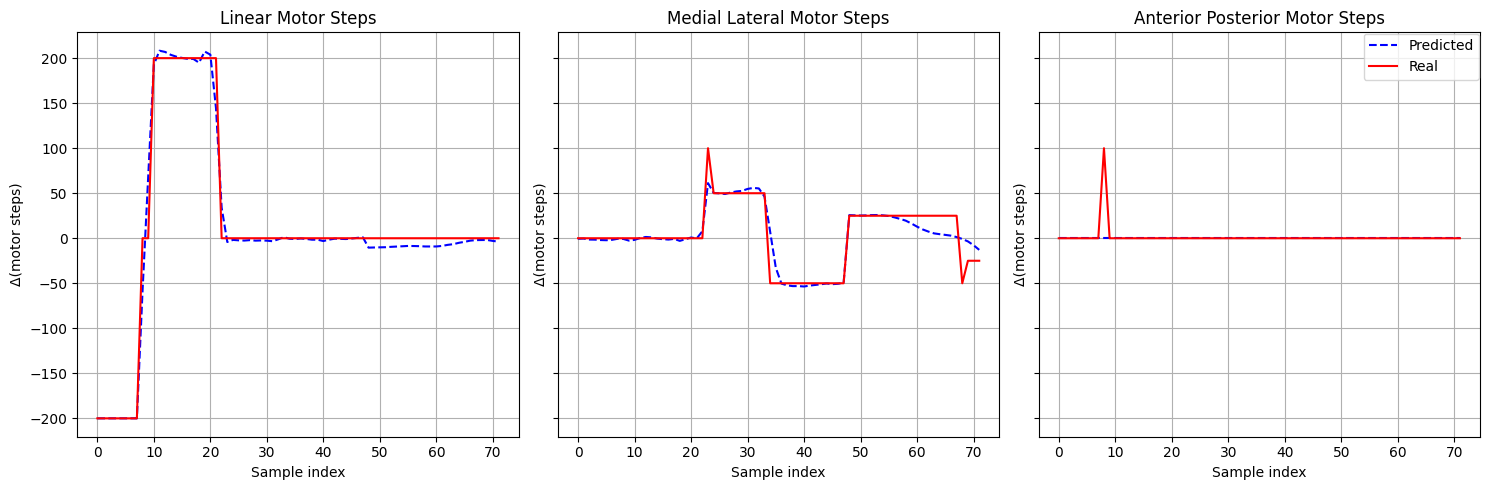

In [ ]:
test_unscaled = predictions_unsc

import matplotlib.pyplot as plt

# Assuming test_unscaled and y_test_unscaled are numpy arrays

# Create subplots with shared y-axis
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Plot for each column
for i, motor_step in enumerate(['Linear', 'Medial Lateral', 'Anterior Posterior']):
    axs[i].plot(test_unscaled[:, i], color='b', linestyle='--', label='Predicted')
    axs[i].plot(y_test_unsc[:, i], color='r', label='Real')  # Dotted line

    axs[i].set_xlabel('Sample index')
    axs[i].set_ylabel('Δ(motor steps)')
    axs[i].set_title(f'{motor_step} Motor Steps')
    axs[i].legend().set_visible(False)  # Hide legend in each subplot
    axs[i].grid(True)

# Create a single legend inside the third plot
fig.legend(loc='upper right', bbox_to_anchor=(0.994, 0.9365), labels=['Predicted', 'Real'])

plt.tight_layout()
plt.show()


#### test on actual, external test dataset

In [ ]:
%ls data/

original_data/    train_100ML_transf.xlsx  train_50ML_transf.xlsx
test_transf.xlsx  train_25ML_transf.xlsx


In [ ]:
data_TEST = pd.read_excel('data/test_transf.xlsx')
data_TEST[40:50]

,LIN,ML,AP,x,y,z,q1,q2,q3,q4
40,800,0,200,3.183245,-0.583919,-3.222465,0.044608,0.106655,-0.014541,0.993188
41,600,0,200,2.853034,-0.415399,-3.876402,0.044927,0.106060,-0.015731,0.993220
42,400,0,200,2.657006,-0.258865,-4.271532,0.045196,0.104591,-0.016005,0.993359
43,200,0,200,2.631890,-0.315958,-4.150056,0.044899,0.104706,-0.015391,0.993370
44,0,0,200,2.473691,-0.464790,-3.777891,0.043685,0.104986,-0.013730,0.993419
45,0,0,250,2.476200,-0.689737,-3.293397,0.043889,0.106233,-0.013094,0.993286
46,0,0,250,2.531126,-0.755773,-2.684367,0.043678,0.107926,-0.013291,0.993110
47,200,0,250,2.494115,-0.771717,-2.008985,0.044675,0.108571,-0.013275,0.992996
48,400,0,250,2.508724,-0.801107,-1.303241,0.044216,0.108606,-0.012255,0.993025
49,600,0,250,2.569040,-0.911543,-0.597930,0.045143,0.108539,-0.011361,0.993002


preprocessing steps:
- calculate deltas
- scale everything with 3 existing scalers
- make sequences
- predict

In [ ]:
delta_TEST = make_deltas(data_TEST.iloc[:,:3])
delta_TEST[40:50]

,LIN,ML,AP
40,-200,0,0
41,-200,0,0
42,-200,0,0
43,-200,0,0
44,0,0,50
45,0,0,0
46,200,0,0
47,200,0,0
48,200,0,0
49,200,0,0


In [ ]:
X_TEST_prep = data_TEST.iloc[:,3:]
y_TEST_prep = data_TEST.iloc[:,:3]

X_TEST_prep = scaler_pos.transform(X_TEST_prep)
y_TEST_prep = scaler_motor.transform(y_TEST_prep)
delta_TEST_prep = scaler_delta.transform(delta_TEST)

In [ ]:
y_TEST_prep.shape

(180, 3)

In [ ]:
X_TEST, y_TEST = build_sequences(np.copy(X_TEST_prep),np.copy(y_TEST_prep),window,stride,pred_window,dataDelta=np.copy(delta_TEST_prep))
print(X_TEST.shape, y_TEST.shape)

(154, 25, 10) (154, 1, 3)


In [ ]:
%ls models/models_RNN

model_LSTMCONV_1402_/  model_LSTMCONV_1402_2/  model_LSTMCONV_1502_3/


In [ ]:
model = keras.models.load_model('models/models_RNN/model_LSTMCONV_1402_2')

#### model LSTMCONV_1402_2

In [ ]:
# Predict the test set using the model
predictions_TEST = model.predict(X_TEST, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions_TEST.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = keras.metrics.mean_squared_error(y_TEST.flatten(), predictions_TEST.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = keras.metrics.mean_absolute_error(y_TEST.flatten(), predictions_TEST.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (154, 3)
Mean Squared Error: 0.43713656067848206
Mean Absolute Error: 0.1776367872953415


In [ ]:
# keras tuned model new
y_TEST = y_TEST.reshape(-1,3)
MAElin = np.mean(np.abs(y_TEST[:, 0] - predictions_TEST[:, 0]))
MAEml = np.mean(np.abs(y_TEST[:, 1] - predictions_TEST[:, 1]))
MAEap = np.mean(np.abs(y_TEST[:, 2] - predictions_TEST[:, 2]))
print(f'MAE lin: {MAElin}\nMAE ml: {MAEml}\nMAE ap: {MAEap}')

MAE lin: 0.10444623110936833
MAE ml: 0.418723957177687
MAE ap: 0.00974025974025974


In [ ]:
# keras tuned results
predictions_unsc_TEST = scaler_delta.inverse_transform(predictions_TEST)
y_TEST_unsc = scaler_delta.inverse_transform(y_TEST.reshape(-1,3))

for i in range(len(predictions_unsc_TEST)):
  print(f'predicted: {predictions_unsc_TEST[i]} -- real: {y_TEST_unsc[i]}')

predicted: [12.467122 48.161743  0.      ] -- real: [  0. -50.   0.]
predicted: [12.338257 12.502456  0.      ] -- real: [  0. -50.   0.]
predicted: [  6.3937902 -21.42076     0.       ] -- real: [  0. -50.   0.]
predicted: [ -0.22619963 -48.144836     0.        ] -- real: [  0. -50.   0.]
predicted: [ -5.415678 -73.094734   0.      ] -- real: [  0. -50.   0.]
predicted: [ -9.700357 -94.3332     0.      ] -- real: [  0. -50.   0.]
predicted: [  -9.542406 -100.          0.      ] -- real: [  0. -50.   0.]
predicted: [ -5.2703857 -96.59401     0.       ] -- real: [    0. -1100.     0.]
predicted: [  -2.6478648 -100.           0.       ] -- real: [-200.    0.    0.]
predicted: [  -3.8339376 -100.           0.       ] -- real: [-200.    0.    0.]
predicted: [  -6.486261 -100.          0.      ] -- real: [-200.    0.    0.]
predicted: [ -10.322094 -100.          0.      ] -- real: [-200.    0.    0.]
predicted: [ -5.202675 -97.33907    0.      ] -- real: [-200.    0.    0.]
predicted: [-40.

In [ ]:
# keras tuned model
y_test = y_test.reshape(-1,3)
MAElin = np.mean(np.abs(y_TEST_unsc[:, 0] - predictions_unsc_TEST[:, 0]))
MAEml = np.mean(np.abs(y_TEST_unsc[:, 1] - predictions_unsc_TEST[:, 1]))
MAEap = np.mean(np.abs(y_TEST_unsc[:, 2] - predictions_unsc_TEST[:, 2]))
print(f'MAE lin: {MAElin}\nMAE ml: {MAEml}\nMAE ap: {MAEap}')

MAE lin: 41.7784927448669
MAE ml: 83.74479121511632
MAE ap: 0.974025974025974


In [ ]:
np.mean([MAElin,MAEml,MAEap])

42.16576997800306

In [ ]:
max(predictions_TEST[:,0])

1.009824

#### model LSTMCONV_1502_3

In [ ]:
# Predict the test set using the model
predictions_TEST = model.predict(X_TEST, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions_TEST.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = keras.metrics.mean_squared_error(y_TEST.flatten(), predictions_TEST.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = keras.metrics.mean_absolute_error(y_TEST.flatten(), predictions_TEST.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (154, 3)
Mean Squared Error: 0.43477481603622437
Mean Absolute Error: 0.18524064123630524


In [ ]:
y_TEST.shape

(154, 1, 3)

In [ ]:
# keras tuned model new
y_TEST = y_TEST.reshape(-1,3)
MAElin = np.mean(np.abs(y_TEST[:, 0] - predictions_TEST[:, 0]))
MAEml = np.mean(np.abs(y_TEST[:, 1] - predictions_TEST[:, 1]))
MAEap = np.mean(np.abs(y_TEST[:, 2] - predictions_TEST[:, 2]))
print(f'MAE lin: {MAElin}\nMAE ml: {MAEml}\nMAE ap: {MAEap}')

MAE lin: 0.11779830372565753
MAE ml: 0.42818335937215135
MAE ap: 0.00974025974025974


### save model

In [ ]:
# %cd /models
%ls

 checkpoints/                               literature/         RNN_final.ipynb
'Copia di FFNN_final.ipynb'                 logs/               transform_data.ipynb
'Copia di RNN_0602_experimentation.ipynb'   models/             tuner_hyperparams/
'Copia di RNN_version3.ipynb'               README.txt          Untitled0.ipynb
 data/                                      RNN_0602.ipynb      untitled_project/
 FFNN_final.ipynb                           RNN_final_D.ipynb


In [ ]:
#save model
# model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
import time
name = 'model_LSTMCONV_1502_3'#+str(round(time.time()))
model.save(f'models/models_RNN/{name}')